## Topic Modeling

In [36]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora, models
import pandas as pd
from nltk import FreqDist
import re
import spacy

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
nltk.download('stopwords')
!python -m spacy download en # one time run

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amandeep\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
# change this to reviews.csv
reviews_df = pd.read_json('Automotive_5.json', lines=True)
reviews_body = "reviewText" # set review text column name here 
reviews_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [21]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

In [16]:
# remove unwanted characters, numbers and symbols
reviews_df[reviews_body] = reviews_df[reviews_body].str.replace("[^a-zA-Z#]", " ")
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
reviews_df[reviews_body] = reviews_df[reviews_body].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in reviews_df[reviews_body]]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

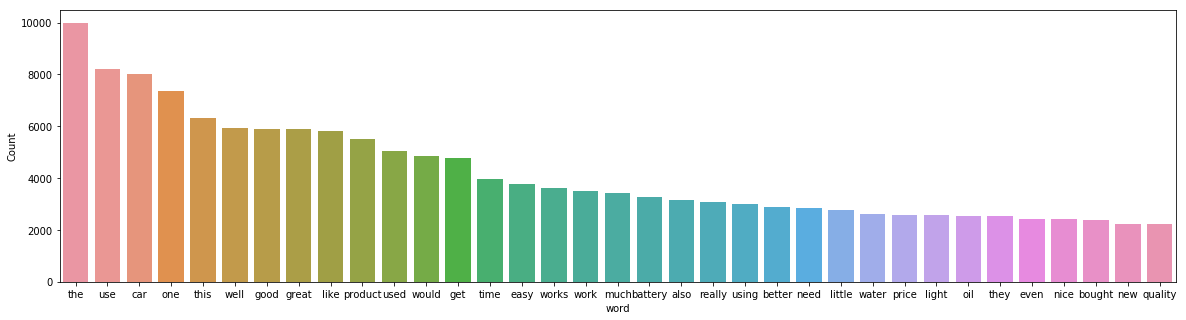

In [24]:
freq_words(reviews, 35)

In [33]:
from spacy.lang.en import English

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [41]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']
['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


In [42]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

NameError: name 'df' is not defined

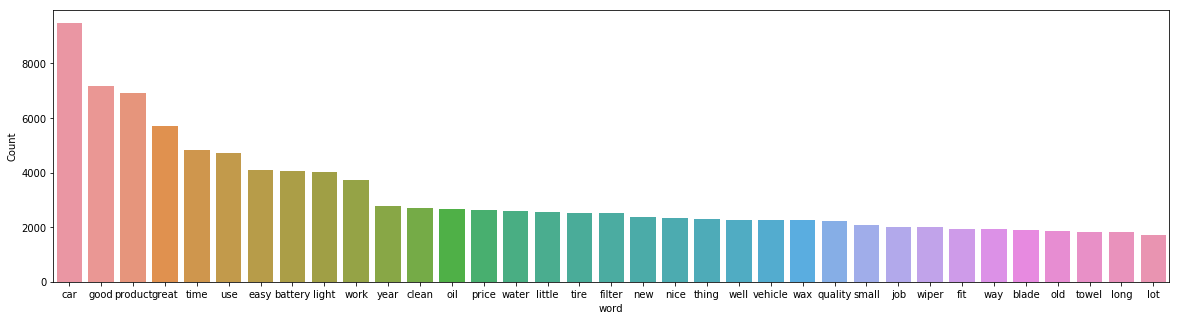

In [43]:
reviews_df['reviews'] = reviews_3

freq_words(reviews_df['reviews'], 35)

## Building Model

In [45]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, num_topics = 7, random_state = 44,
                chunksize = 1000, passes = 50)

In [46]:
lda_model.print_topics()

[(0,
  '0.026*"good" + 0.020*"price" + 0.019*"product" + 0.015*"quality" + 0.015*"great" + 0.012*"device" + 0.011*"time" + 0.011*"filter" + 0.011*"work" + 0.011*"amazon"'),
 (1,
  '0.046*"car" + 0.033*"product" + 0.024*"towel" + 0.018*"good" + 0.017*"clean" + 0.017*"wax" + 0.013*"use" + 0.013*"great" + 0.012*"water" + 0.012*"time"'),
 (2,
  '0.037*"wiper" + 0.036*"blade" + 0.023*"hose" + 0.021*"water" + 0.016*"windshield" + 0.011*"rain" + 0.010*"side" + 0.010*"snow" + 0.009*"tank" + 0.009*"old"'),
 (3,
  '0.051*"light" + 0.025*"bulb" + 0.020*"oil" + 0.017*"bright" + 0.015*"car" + 0.010*"white" + 0.008*"engine" + 0.008*"color" + 0.008*"inverter" + 0.007*"change"'),
 (4,
  '0.043*"battery" + 0.028*"car" + 0.020*"power" + 0.019*"light" + 0.016*"unit" + 0.014*"plug" + 0.013*"charger" + 0.011*"phone" + 0.010*"charge" + 0.010*"code"'),
 (5,
  '0.059*"tire" + 0.023*"trailer" + 0.023*"gauge" + 0.020*"pressure" + 0.017*"jack" + 0.014*"easy" + 0.013*"use" + 0.009*"air" + 0.008*"valve" + 0.008*"t

In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063761 -0.145776       1        1  20.683102
0      0.024027 -0.087756       2        1  20.586767
6     -0.158312 -0.124818       3        1  13.838908
3      0.199606  0.065674       4        1  13.621993
4      0.159368  0.172746       5        1  13.103202
2     -0.044697 -0.099283       6        1  10.884294
5     -0.243754  0.219212       7        1   7.281735, topic_info=     Category         Freq        Term        Total  loglift  logprob
152   Default  5132.000000       light  5132.000000  30.0000  30.0000
38    Default  3126.000000     battery  3126.000000  29.0000  29.0000
335   Default  2369.000000        tire  2369.000000  28.0000  28.0000
939   Default  2180.000000       wiper  2180.000000  27.0000  27.0000
966   Default  2171.000000       blade  2171.000000  26.0000  26.0000
3     Default  9433.000000         car  9433.000000  25.0000  25.0000
529   Default  2692.000000       towel  2692.000000  24.0000  24.0000
316   Default  6405.000000     product  6405.000000  23.0000  23.0000
2596  Default  1834.000000        bulb  1834.000000  22.0000  22.0000
524   Default  2679.000000       water  2679.000000  21.0000  21.0000
1326  Default  1697.000000     leather  1697.000000  20.0000  20.0000
18    Default  2390.000000       price  2390.000000  19.0000  19.0000
728   Default  1391.000000        hose  1391.000000  18.0000  18.0000
525   Default  1903.000000         wax  1903.000000  17.0000  17.0000
63    Default  1607.000000       power  1607.000000  16.0000  16.0000
170   Default  1656.000000         oil  1656.000000  15.0000  15.0000
1283  Default  1296.000000      bright  1296.000000  14.0000  14.0000
76    Default   903.000000     trailer   903.000000  13.0000  13.0000
50    Default   900.000000       gauge   900.000000  12.0000  12.0000
762   Default  1405.000000      device  1405.000000  11.0000  11.0000
1115  Default  1030.000000    pressure  1030.000000  10.0000  10.0000
938   Default   978.000000  windshield   978.000000   9.0000   9.0000
733   Default  1207.000000        unit  1207.000000   8.0000   8.0000
30    Default  2048.000000     quality  2048.000000   7.0000   7.0000
793   Default  1026.000000        plug  1026.000000   6.0000   6.0000
978   Default  1276.000000      filter  1276.000000   5.0000   5.0000
523   Default  1258.000000        wash  1258.000000   4.0000   4.0000
97    Default  2466.000000       clean  2466.000000   3.0000   3.0000
1201  Default   899.000000     charger   899.000000   2.0000   2.0000
648   Default  1155.000000       paint  1155.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1529   Topic7    97.866753     walmart    98.584755   2.6125  -6.0118
494    Topic7    95.921097      height    96.637421   2.6124  -6.0319
4838   Topic7    93.614990        tint    94.338654   2.6121  -6.0562
431    Topic7    90.652466       pound    91.370163   2.6119  -6.0883
2164   Topic7    90.658913        info    91.382195   2.6119  -6.0883
4823   Topic7    87.167160      camera    87.886345   2.6116  -6.1276
1115   Topic7   807.319031    pressure  1030.752686   2.3755  -3.9017
1451   Topic7   236.784409      camper   301.074158   2.3796  -5.1282
866    Topic7   172.244614        lift   205.452469   2.4435  -5.4465
1098   Topic7   339.545593       valve   522.862427   2.1881  -4.7678
3888   Topic7   133.400574     digital   150.970093   2.4961  -5.7020
151    Topic7   257.268829       level   378.450378   2.2338  -5.0453
471    Topic7   302.378906       board   483.119385   2.1512  -4.8837
135    Topic7   221.124619      ground   317.368469   2.2585  -5.1967
1022   Topic7   213.647781      mirror   354.220215   2.1142  -5.2311
506    Topic7   371.081177         air  1117.930664   1.5170  -4.6790
114    Topic7   543.379700        easy  3683.984619   0.7059  -4.2976
328    Topic7   175.467163       space   